# Automatic emittance measurement at LCLS-II
In this case we have 4 quadrupoles, 3 that are used to minimize the incoming beam and
 the fourth to perform the quad scan measurement.

In [1]:
# optionally add scripts location to path
if True:
    import sys
    sys.path.append("../../../")
    sys.path.append("../")

import xopt
print(xopt.__version__)

# set up data saving locations
data_dir = "/home/physics3/ml_tuning/20230813_LCLS2_Injector_new_emit"

run_name = "characterize_1"
run_dir = f"{data_dir}/{run_name}"
import os
if not os.path.exists(run_dir):
    os.mkdir(run_dir)

2.0a1+63.g53057de


In [2]:
from scripts.evaluate_function.screen_image import measure_background
from scripts.characterize_emittance import characterize_emittance
from xopt import VOCS

In [3]:
from utils import VARIABLE_RANGES, SCAN_VARIABLE, \
    MEASUREMENT_OPTIONS, IMAGE_CONSTRAINTS, SCREEN_NAME


## (Optional) Measure background image

In [4]:
MEASURE_BACKGROUND = False
BACKGROUND_FILE = f"{data_dir}/{SCREEN_NAME}_background.npy".replace(":","_")

if MEASURE_BACKGROUND:
    measure_background(SCREEN_NAME)

import pandas as pd
MEASUREMENT_OPTIONS["background"] = BACKGROUND_FILE
MEASUREMENT_OPTIONS["n_shots"] = 5
MEASUREMENT_OPTIONS["visualize"] = False
MEASUREMENT_OPTIONS["save_img_location"] = run_dir
#MEASUREMENT_OPTIONS["roi"] = pd.Series([600,625,700,700])


In [5]:
BACKGROUND_FILE

'/home/physics3/ml_tuning/20230813_LCLS2_Injector_new_emit/OTRS_HTR_330_background.npy'

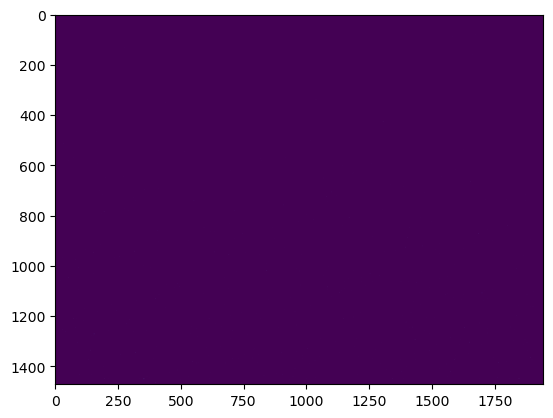

In [6]:
# verify background image
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.load(BACKGROUND_FILE))

In [7]:
MEASUREMENT_OPTIONS

{'screen': 'OTRS:HTR:330',
 'background': '/home/physics3/ml_tuning/20230813_LCLS2_Injector_new_emit/OTRS_HTR_330_background.npy',
 'roi': None,
 'bb_half_width': 3.0,
 'visualize': False,
 'n_shots': 5,
 'save_img_location': '/home/physics3/ml_tuning/20230813_LCLS2_Injector_new_emit/characterize_1'}

In [8]:
IMAGE_CONSTRAINTS

{'bb_penalty': ['LESS_THAN', 0.0],
 'log10_total_intensity': ['GREATER_THAN', 4]}

## Automatic quad scan and emittance characterization

In [9]:
from emitopt.utils import get_quad_strength_conversion_factor
from utils import BEAM_ENERGY, QUAD_LENGTH, DRIFT_LENGTH, PV_TO_INTEGRATED_GRADIENT, eval_beamsize

# modify variable ranges for QE01
VARIABLE_RANGES["QUAD:HTR:120:BCTRL"] = [-2.2, -1.8]

emit_vocs = VOCS(
        variables = {SCAN_VARIABLE: VARIABLE_RANGES[SCAN_VARIABLE]},
        observables = ["S_x_mm", "S_y_mm"],
        constraints = IMAGE_CONSTRAINTS,
        constants = MEASUREMENT_OPTIONS
    )


In [10]:
emit_vocs

VOCS(variables={'QUAD:HTR:120:BCTRL': [-2.2, -1.8]}, constraints={'bb_penalty': ['LESS_THAN', 0.0], 'log10_total_intensity': ['GREATER_THAN', 4.0]}, objectives={}, constants={'screen': 'OTRS:HTR:330', 'background': '/home/physics3/ml_tuning/20230813_LCLS2_Injector_new_emit/OTRS_HTR_330_background.npy', 'roi': None, 'bb_half_width': 3.0, 'visualize': False, 'n_shots': 5, 'save_img_location': '/home/physics3/ml_tuning/20230813_LCLS2_Injector_new_emit/characterize_1'}, observables=['S_x_mm', 'S_y_mm'])

CAPUT QUAD:HTR:120:BCTRL -2.0725296805124676
3
fitting time:2.572676658630371
3
fitting time:2.5816354751586914
3
fitting time:2.441086769104004
3
fitting time:2.2914621829986572
3
fitting time:1.7275605201721191
{'Cx': [1014.2560506262918, 1014.1988496434144, 1014.2575348173029, 1014.4331069904297, 1014.3761239521529], 'Cy': [929.0444535024975, 928.0557907543141, 928.756564532085, 928.3543937347193, 810.7809141869869], 'Sx': [81.3515619492387, 83.94239391716819, 75.67485860997164, 72.6477251332456, 78.27616538937025], 'Sy': [154.94110372486543, 155.6465229361155, 162.1123810563815, 145.28574828386226, 19.57], 'bb_penalty': [-437.7182383876128, -437.13994926636366, -438.25071528522534, -439.0223839748316, -402.40464613018753], 'total_intensity': [378306.0500000001, 388330.3000000002, 385950.15000000014, 385136.5499999999, 391495.39999999973], 'log10_total_intensity': [5.577843286734472, 5.589201278285963, 5.586531214055145, 5.585614735735384, 5.592726663542485], 'time': [1691987210.859

/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/emitopt/utils.py:967: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/emitopt/utils.py:968: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, **tkwargs)


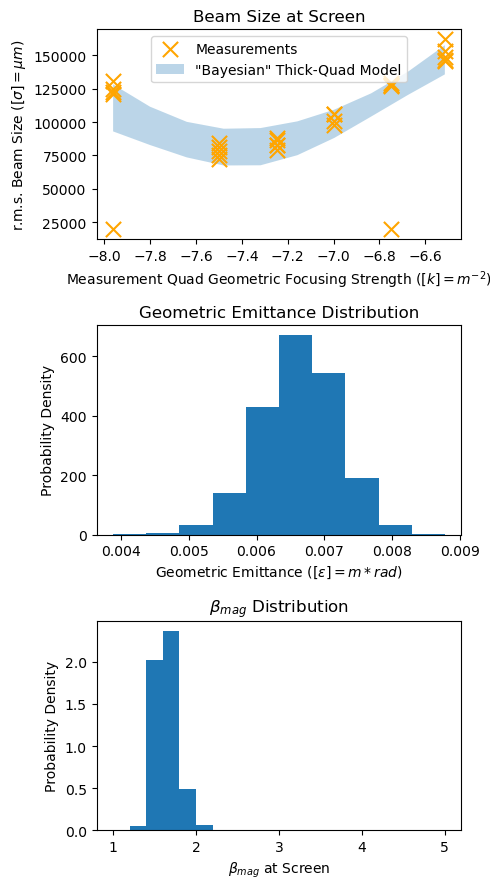

/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/emitopt/utils.py:967: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/emitopt/utils.py:968: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, **tkwargs)


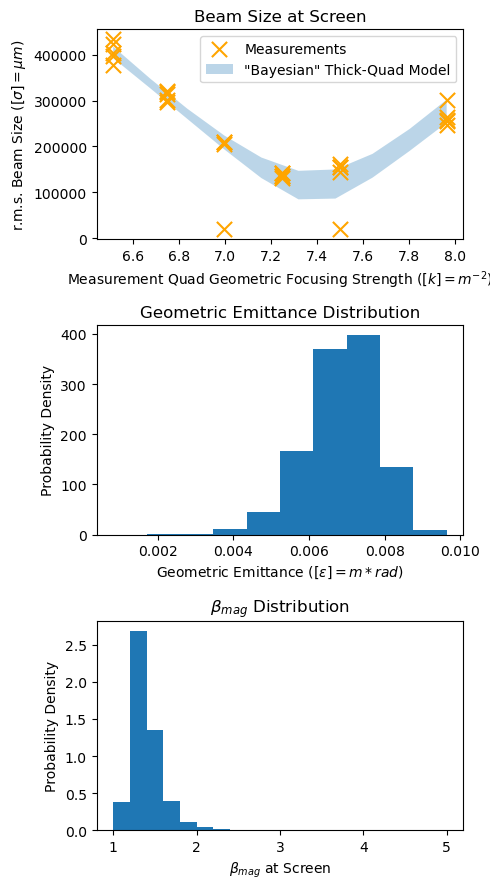

In [11]:

# create conversion factor from PV value to geometric focusing strength
integrated_gradient_to_geometric_focusing_strength = get_quad_strength_conversion_factor(
        BEAM_ENERGY, QUAD_LENGTH
    )
quad_strength_scale_factor =  PV_TO_INTEGRATED_GRADIENT * integrated_gradient_to_geometric_focusing_strength

emit_results, emit_Xopt = characterize_emittance(
    emit_vocs,
    eval_beamsize,
    QUAD_LENGTH,
    DRIFT_LENGTH,
    BEAM_ENERGY,
    quad_strength_key=SCAN_VARIABLE,
    quad_strength_scale_factor=quad_strength_scale_factor,
    rms_x_key="S_x_mm",
    rms_y_key="S_y_mm",
    n_iterations=5,
    quad_scan_analysis_kwargs={"visualize": True}
)

In [16]:
type(emit_results)

dict

In [13]:
emit_Xopt.data.keys()

Index(['QUAD:HTR:120:BCTRL', 'screen', 'background', 'roi', 'bb_half_width',
       'visualize', 'n_shots', 'save_img_location', 'Cx', 'Cy', 'Sx', 'Sy',
       'bb_penalty', 'total_intensity', 'log10_total_intensity', 'time',
       'save_filename', 'S_x_mm', 'S_y_mm', 'total_size', 'xopt_runtime',
       'xopt_error'],
      dtype='object')

In [14]:
emit_Xopt.data["S_x_mm"]

1     0.081352
2     0.083942
3     0.075675
4     0.072648
5     0.078276
6     0.145438
7     0.149097
8     0.162347
9     0.153547
10    0.146331
11     0.01957
12    0.121252
13     0.13103
14    0.122259
15     0.12505
16         NaN
17    0.097443
18    0.100539
19       0.106
20    0.106318
21    0.082878
22    0.079109
23    0.082971
24    0.087828
25    0.086804
26     0.01957
27    0.127821
28    0.129294
29    0.127199
30    0.127767
Name: S_x_mm, dtype: object